## tuning regularization parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import wobble

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#%load_ext line_profiler

In [3]:
starname = '51peg'
r = 57

In [4]:
data = wobble.Data(starname+'_e2ds.hdf5', filepath='data/', orders=[r])
model = wobble.Model(data)
model.add_star(starname)
model.add_telluric('tellurics', rvs_fixed=True, variable_bases=3)

In [5]:
model.components[0].L1_template = 1.e4 # star
model.components[0].L2_template = 1.e5   # star
model.components[1].L1_template = 1.e5 # tellurics
model.components[1].L2_template = 1.e6   # tellurics
model.components[1].L1_basis_vectors = 1.e5
model.components[1].L2_basis_vectors = 1.e6
model.components[1].L2_basis_weights = 1. # by definition

In [6]:
model.components[1].L2_template = 1.e7
model.components[1].L2_basis_vectors = 1.e7
model.components[0].L1_template = 1.e1
model.components[0].L2_template = 1.e1

In [7]:
#%lprun -f wobble.optimize_order wobble.optimize_order(model, data, 0, niter=50, save_history=True, basename=starname) 

In [8]:
results = wobble.optimize_order(model, data, 0, niter=50, save_history=False, basename=starname)
#history = wobble.History(model, data, 0, 50, filename=starname+'_o0_history.hdf5')

100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


In [9]:
#from IPython.display import HTML
#ani = history.plot_template(0,model,data)
#HTML(ani.to_html5_video())

In [10]:
session = wobble.get_session()
#star_ys = session.run(model.components[0].shift_and_interp(0, data.xs[0], model.components[0].rvs_block[0]))
star_ys = getattr(results, '{0}_ys_predicted'.format(starname))[0]
t_ys = results.tellurics_ys_predicted[0]
data_xs = results.xs[0]
data_ys = results.ys[0]
rvs_star = getattr(results, '{0}_rvs_block'.format(starname))[0]
resids = np.exp(data_ys) - np.exp(results.ys_predicted[0])

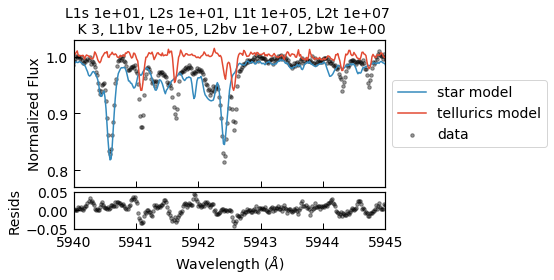

In [11]:
epoch = 12 # random
fig, (ax, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[4, 1]})
ax.plot(np.exp(data_xs[epoch]), np.exp(star_ys[epoch]), label='star model', lw=1.5)
ax.plot(np.exp(data_xs[epoch]), np.exp(t_ys[epoch]), label='tellurics model', lw=1.5)
ax.scatter(np.exp(data_xs[epoch]), np.exp(data_ys[epoch]), marker=".", alpha=0.4, c='k', label='data')
ax.set_xlim([5940, 5945])
ax.set_ylim([0.77, 1.03])
ax.set_xticklabels([])
ax.set_ylabel('Normalized Flux', fontsize=14)
ax2.scatter(np.exp(data_xs[epoch]), resids[epoch], marker=".", alpha=0.4, c='k')
ax2.set_xlim([5940, 5945])
ax2.set_ylim([-0.05, 0.05])
ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
ax2.set_ylabel('Resids', fontsize=14)

# Shrink current axis by 50%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

ax.set_title('L1s {0:.0e}, L2s {1:.0e}, L1t {2:.0e}, L2t {3:.0e} \n K {4}, L1bv {5:.0e}, L2bv {6:.0e}, L2bw {7:.0e}'.format(
    model.components[0].L1_template, model.components[0].L2_template,
    model.components[1].L1_template, model.components[1].L2_template,
    model.components[1].K, model.components[1].L1_basis_vectors, 
    model.components[1].L2_basis_vectors, model.components[1].L2_basis_weights),
    fontsize=14)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)
plt.savefig('regularization/L1s{0:.0e}_L2s{1:.0e}_L1t{2:.0e}_L2t{3:.0e}_K{4}_L1bv{5:.0e}_L2bv{6:.0e}_L2bw{7:.0e}.png'.format(
    model.components[0].L1_template, model.components[0].L2_template,
    model.components[1].L1_template, model.components[1].L2_template,
    model.components[1].K, model.components[1].L1_basis_vectors, 
    model.components[1].L2_basis_vectors, model.components[1].L2_basis_weights));

In [12]:
results.write('results.hdf5')

Results: writing to results.hdf5


In [13]:
results.read('results.hdf5')

Results: reading from results.hdf5


In [14]:
results.component_names

['51peg', 'tellurics']